# Load our video file into memory

Welcome to foosbot

In [1]:
from __future__ import print_function

import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

from video_file import *

import importlib
try:
    importlib.reload(video_file)
except:
    pass

import cv2
import sys
import os
import csv
import numpy as np
from random import randint
from random import shuffle

from PIL import Image
import imageio
import itertools as it

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

import pprint
pp = pprint.PrettyPrinter(depth=6)


# Create the image transformer
transformer = VideoTransform( zoom_range=0.1, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [3,4,5], horizontal_flip_reverse_indices = [0,1,2], data_format='channels_last' )

# Paths relative to current python file.
data_path  = ".\\..\\Recorder\\FeatureSetBuilder\\Experiments\\Experiment3Result\\settings.tsv"

print("Opening training frames from config %s." % (data_path))
position_rel_indexes = [0, 10] # Predict current rod positions and future position in 10 frames
frame_rel_indexes = [0] # Use only current frame as input
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)
training.clear_memory()



Using TensorFlow backend.


Opening training frames from config .\..\Recorder\FeatureSetBuilder\Experiments\Experiment3Result\settings.tsv.
Creating training chunk from .\..\Recorder\FeatureSetBuilder\Experiments\Experiment3Result\chunk0.avi
.\..\Recorder\FeatureSetBuilder\Experiments\Experiment3Result\chunk0.avi
added 15932 new frames for a total of 15932
Creating training chunk from .\..\Recorder\FeatureSetBuilder\Experiments\Experiment3Result\chunk1.avi
.\..\Recorder\FeatureSetBuilder\Experiments\Experiment3Result\chunk1.avi
added 22943 new frames for a total of 38875


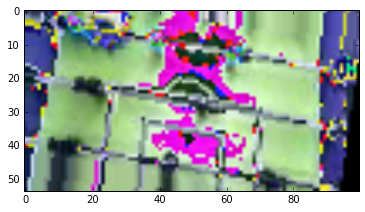

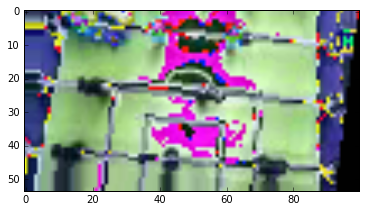

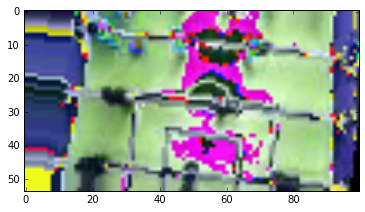

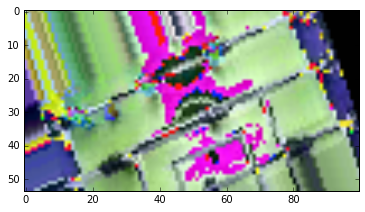

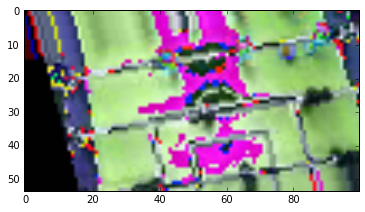

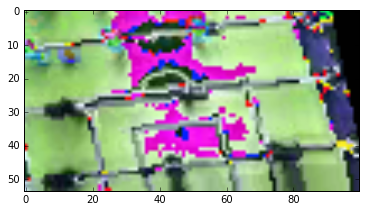

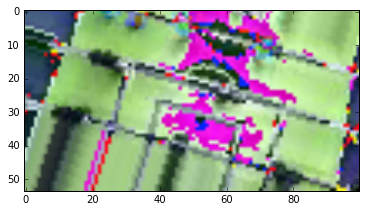

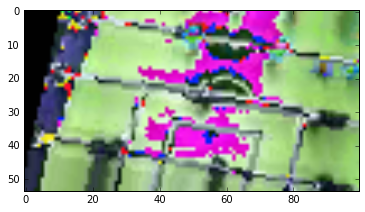

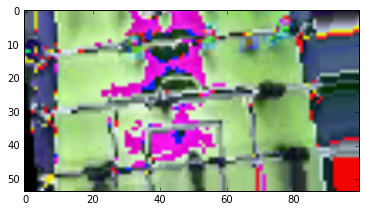

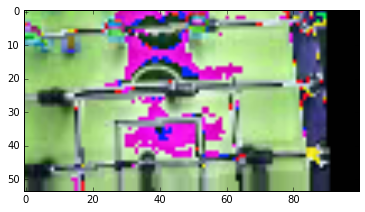

Shape of training input:
(1, 54, 100, 3)
Shape of training output:
(6,)
Corresponding Positions:


,0
0,0.427711
1,0.264493
2,0.224599
3,-0.006024
4,-0.003623
5,-0.010695


In [2]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline

training.move_first_training_frame()

for k in range(10):
    (frame, position) = training.get_next_training_frame()
    data = np.zeros(shape=(np.shape(frame)[1], np.shape(frame)[2] * np.shape(frame)[0], 3), dtype=np.float32)
    for i in range(np.shape(frame)[0]):
        tmp = frame[i,:,:,:]
        data[:,i*np.shape(frame)[2]:(i+1)*np.shape(frame)[2],:] = tmp


    plt.imshow(data,cmap="gray")
    plt.show()

training.move_first_training_frame()

print("Shape of training input:")
pp.pprint(np.shape(frame))

print("Shape of training output:")
pp.pprint(np.shape(position))

print("Corresponding Positions:")
pd.DataFrame(position)




# Train our model using CNTK

In [3]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model


def TrainGen():
    while True:
        #print("TrainGen restarting training input.")
        training.move_first_training_frame()
        (frames, output) = training.get_next_training_frame()
        while frames != None:
            yield (frames, output)
            (frames, output) = training.get_next_training_frame()
            
def ValidateGen():
    while True:
        #print("Validation restarting training input.")
        training.move_first_validation_frame()
        (frames, output) = training.get_next_validation_frame()
        while frames != None:
            yield (frames, output)
            (frames, output) = training.get_next_validation_frame()
            
def TrainBatchGen(batch_size):
    gen = TrainGen()
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, image_depth, image_height, image_width, image_channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, output_size), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output
            batch_outputs[i,3:5] = 3*batch_outputs[i,3:5]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

def ValidateBatchGen(batch_size):
    gen = ValidateGen()
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, image_depth, image_height, image_width, image_channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, output_size), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output
            batch_outputs[i,3:5] = 3*batch_outputs[i,3:5]
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

In [4]:
from keras.models import load_model
epoch = 41

# These values must match for both train and test reader.
image_height       = training.height
image_width        = training.width
image_depth        = training.depth
image_channels     = training.channels
output_size        = training.output_size

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))


# Build a functional model design
# Build a functional model design
inputs = Input(shape=(1, image_height, image_width, image_channels,))
x = Conv3D(124,
           kernel_size = (1, 5, 5),
           padding = "same")(inputs)
x = Activation('relu')(x)

x = Conv3D(124,
           kernel_size = (1, 5, 5),
           padding = "same")(x)
x = Activation('relu')(x)

# Split into two sum images
x1 = MaxPooling3D( pool_size=(1, 2, 1))(x) # (?, 54, 100, 128, 1 )
x2 = MaxPooling3D( pool_size=(1, 1, 2))(x) # (?, 54, 100, 128, 1 )

x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = MaxPooling3D( pool_size=(1, 2, 1))(x1)



x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = MaxPooling3D( pool_size=(1, 2, 1))(x1)

x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = MaxPooling3D( pool_size=(1, 1, 2))(x1)

x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = MaxPooling3D( pool_size=(1, 1, 2))(x1)

x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = MaxPooling3D( pool_size=(1, 1, 2))(x1)

x1 = Flatten()(x1)



x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 2, 1))(x2)

x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 2, 1))(x2)

x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 2, 1))(x2)

x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 1, 2))(x2)

x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 1, 2))(x2)

x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 1, 2))(x2)

x2 = Flatten()(x2)


x = keras.layers.concatenate([x1, x2])

#x = Flatten()(x1)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='linear')(x)

model = Model(inputs=inputs, outputs=predictions)


#epoch = 45
#WEIGHTS_FNAME = 'config5_iter%i.hdf'
#model.load_weights(WEIGHTS_FNAME % epoch)
#print("Loaded model.")

#model.optimizer.lr.assign(0.00000001)

# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

WEIGHTS_FNAME = 'mnist_cnn_weights_62.hdf'





#model.load_weights(WEIGHTS_FNAME % epoch)
#model.load_weights("config10.hdf")
model.load_weights('mnist_cnn_weights_62.hdf')

#model = load_model('mnist_cnn_weights_62.hdf')
print("Loaded model.")

#output_true = labels_validate
#output_predicted = model.predict(data_validate, batch_size=32, verbose=1)
#print("Predicted.")


'Input shape without batches:'
(54, 100, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 54, 100, 3) 0                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 1, 54, 100, 12 9424        input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1, 54, 100, 12 0           conv3d_1[0][0]                   
____________________________________________________________________________________________________
conv3d_2 (Conv3D)                (None, 1, 54, 100, 12 384524      activation_1[0][0]               
_______________________________________________

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


10000/10000 [==============================] - 91s    
Predicted.
array([[ 0.30722892,  0.52536231,  0.58288771,  0.41566265,  0.10869565,
         0.06417112],
       [ 0.3253012 ,  0.5289855 ,  0.58288771,  0.66867471,  0.27173913,
         0.09625668],
       [ 0.34337351,  0.5289855 ,  0.59893048,  0.92168677,  0.46739128,
         0.11229946],
       ..., 
       [ 0.04819277,  0.34782609,  0.28342247,  1.39156628,  0.9891305 ,
         0.13903743],
       [ 0.02409638,  0.34782609,  0.33689839,  1.5       ,  1.01086962,
         0.12299465],
       [ 0.02409638,  0.34782609,  0.35828876,  1.55421686,  1.02173913,
         0.13368984]], dtype=float32)
array([[  4.74905342e-01,   6.08125150e-01,   6.02347374e-01,
          3.19254920e-02,  -8.92456621e-03,  -2.62537822e-02],
       [  4.75182444e-01,   6.11788988e-01,   6.03678107e-01,
          3.08000185e-02,  -1.06259547e-02,  -2.65489295e-02],
       [  4.81871635e-01,   5.83964825e-01,   6.01220727e-01,
          3.20346914e-0

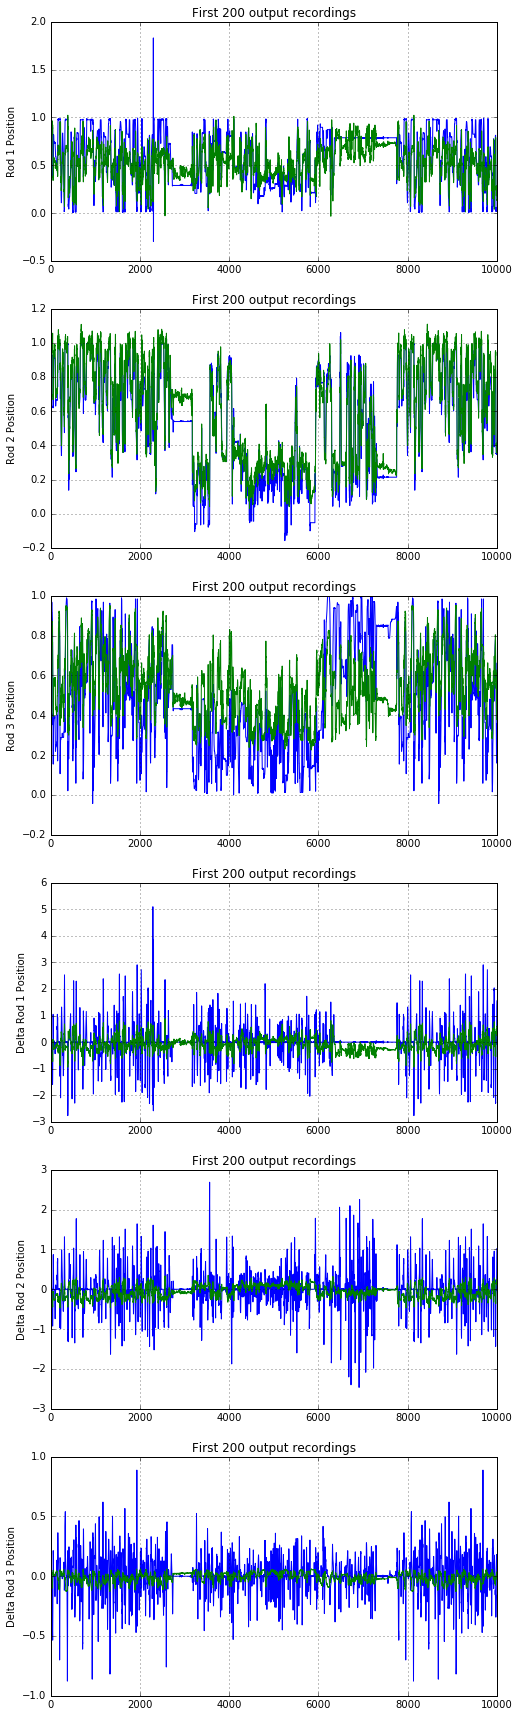

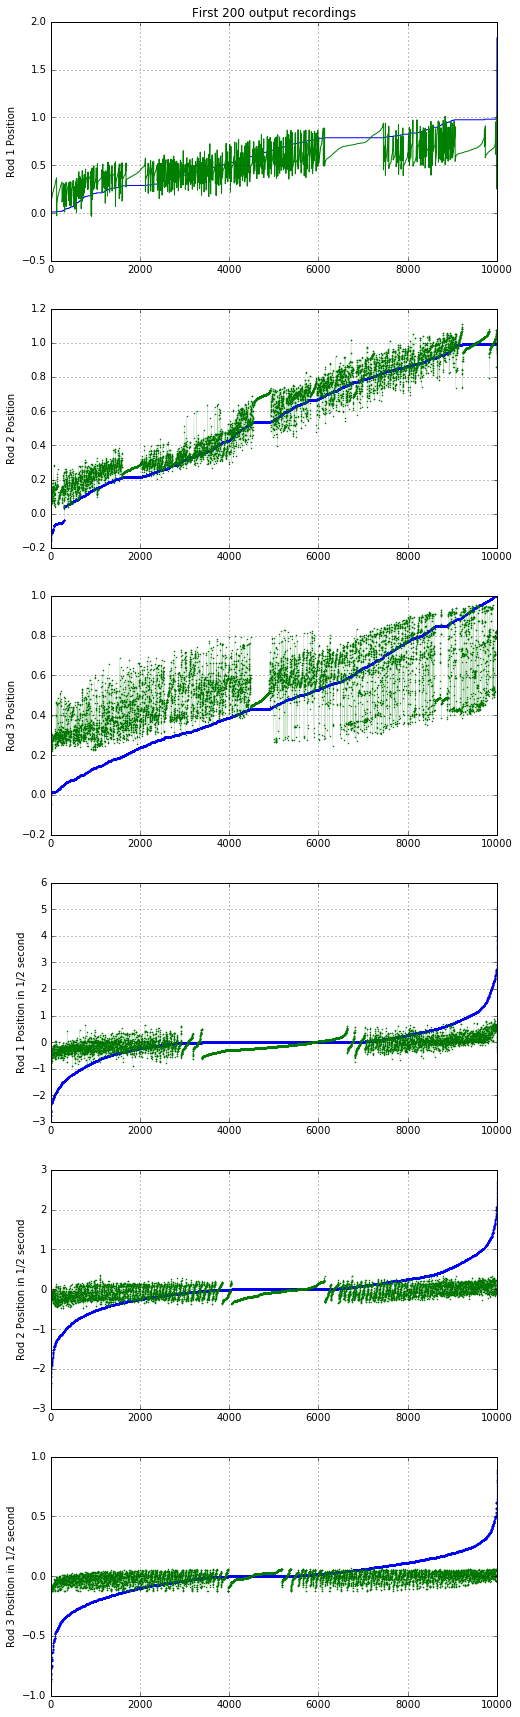

In [7]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline


def plot_validate():
    (frames, outputs_true) = next(ValidateBatchGen(10000))
    #frames = np.squeeze(frames, axis=(1,))
    #validate_in, validate_out
    #frames = validate_in
    #outputs_true =validate_out
    outputs_predicted = model.predict(frames, batch_size=24, verbose=1)
    print("Predicted.")
    
    
    pp.pprint(outputs_true)
    pp.pprint(outputs_predicted)
    
    
    plt.figure(figsize=(8,30))
    count = 10000
    
    plt.subplot(611)
    plt.plot(range(count),outputs_true[0:count,0], range(count),outputs_predicted[0:count,0] )
    plt.ylabel("Rod 1 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(612)
    plt.plot(range(count),outputs_true[0:count,1], range(count),outputs_predicted[0:count,1] )
    plt.ylabel("Rod 2 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(613)
    plt.plot(range(count),outputs_true[0:count,2], range(count),outputs_predicted[0:count,2] )
    plt.ylabel("Rod 3 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(614)
    plt.plot(range(count),outputs_true[0:count,3], range(count),outputs_predicted[0:count,3] )
    plt.ylabel("Delta Rod 1 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(615)
    plt.plot(range(count),outputs_true[0:count,4], range(count),outputs_predicted[0:count,4] )
    plt.ylabel("Delta Rod 2 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(616)
    plt.plot(range(count),outputs_true[0:count,5], range(count),outputs_predicted[0:count,5] )
    plt.ylabel("Delta Rod 3 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    
    plt.figure(figsize=(8,30))
    plt.subplot(611)
    

    true, predicted = zip(*sorted(zip(outputs_true[0:count,0], outputs_predicted[0:count,0])))
    plt.plot(range(count),true, range(count),predicted )
    plt.ylabel("Rod 1 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(612)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,1], outputs_predicted[0:count,1])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 2 Position")
    plt.grid(True)
    
    plt.subplot(613)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,2], outputs_predicted[0:count,2])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 3 Position")
    plt.grid(True)
    
    plt.subplot(614)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,3], outputs_predicted[0:count,3])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 1 Position in 1/2 second")
    plt.grid(True)
    
    plt.subplot(615)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,4], outputs_predicted[0:count,4])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 2 Position in 1/2 second")
    plt.grid(True)
    
    plt.subplot(616)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,5], outputs_predicted[0:count,5])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 3 Position in 1/2 second")
    plt.grid(True)
    
    plt.show()
    
plot_validate()

# Visualizing the result

In [3]:
step = 1000


rod_positions = [0,1,2]
rod_deltas = [3,4,5]

while(True):
    (frames, outputs_true) = next(ValidateBatchGen(1))
    outputs_predicted = model.predict(frames, batch_size=1, verbose=1)
    
    # Show the frame with overlayed rod positions
    frame = np.squeeze(outputs_true[0,0,:,:,:])
    plt.imshow(frame,cmap="gray")
    plt.show()
    break



NameError: name 'ValidateBatchGen' is not defined

In [ ]:
# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_depth, image_height, image_width, image_channels))
model = Sequential([

    Conv3D(128,
           input_shape=(image_depth, image_height, image_width, image_channels),
           data_format="channels_last",
           kernel_size = (1, 3, 3),
           padding = "same"),
    
    Activation('relu'),
        
    Conv3D(128,
           data_format="channels_last",
           kernel_size = (1, 3, 3),
           padding = "same"),
        
    Activation('relu'),
    
    Conv3D(128,
           data_format="channels_last",
           kernel_size = (1, 3, 3),
           padding = "same"),
        
    Activation('relu'),
        
    Conv3D(128,
           data_format="channels_last",
           kernel_size = (1, 3, 3),
           padding = "same"),
        
    Activation('relu'),
        
    Conv3D(128,
           data_format="channels_last",
           kernel_size = (1, 3, 3),
           padding = "same"),
        
    Activation('relu'),
        
    MaxPooling3D( pool_size=(1, 1, 2),
                  data_format="channels_last"),
        
    Conv3D(128,
           data_format="channels_last",
           kernel_size = (1, 3, 3),
           padding = "same"),
        
    Activation('relu'),
        
    Conv3D(128,
           data_format="channels_last",
           kernel_size = (1, 3, 3),
           padding = "same"),
        
    Activation('relu'),
        
    Conv3D(128,
           data_format="channels_last",
           kernel_size = (1, 3, 3),
           padding = "same"),
        
    Activation('relu'),
        
    Conv3D(128,
           data_format="channels_last",
           kernel_size = (1, 3, 3),
           padding = "same"),
        
    Activation('relu'),
        
    
    MaxPooling3D( pool_size=(1, 54, 1),
                  data_format="channels_last"),
    
        
    Conv3D(256,
       data_format="channels_last",
       kernel_size = (1, 1, 3),
       padding = "same"),
        
    Activation('relu'),
        
    Conv3D(256,
       data_format="channels_last",
       kernel_size = (1, 1, 3),
       padding = "same"),
        
    Activation('relu'),
        
    MaxPooling3D( pool_size=(1, 1, 2),
                  data_format="channels_last"),
        
    Conv3D(256,
       data_format="channels_last",
       kernel_size = (1, 1, 3),
       padding = "same"),
        
    Activation('relu'),
        
    Conv3D(256,
       data_format="channels_last",
       kernel_size = (1, 1, 3),
       padding = "same"),
        
    Activation('relu'),
        
    MaxPooling3D( pool_size=(1, 1, 2),
                  data_format="channels_last"),
    
    Conv3D(256,
       data_format="channels_last",
       kernel_size = (1, 1, 3),
       padding = "same"),
        
    Activation('relu'),
        
    Flatten(),
    
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
        
    Dense(32),
    Activation('relu'),
    Dropout(0.5),
        
    
    Dense(6),
])
